# Argon simulation

#### Constants en parameters

In [1]:
import numpy as np
import math
from numba import jit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# constants - used to calculate endresults in SI. Computation is in natural units, i.e. m=1 eps=1 sigma=1.
kb = 1.38 * 10**(-23) #J/K
eps_per_kb = 120 #K
sigma = 0.34*10**(-9) #m
m = 6.633853*10**(-26) #kg - mass of argon atom
tau = math.sqrt(m*sigma*sigma/eps_per_kb/kb) #s - typical unit of time.

#### ----------------------------------- Parameters
# adjustable params (Natural units!)
rho = 1.0              #width of the box in sigma
Tinit = 0.001                 #For fixed energy computation, must be scalar
Tfixed = 0.1                #For fixed temperature computation, must be a range
n = 4                  #Number of unit cells per dimension
dt = 0.004                #In natural units
timesteps = 4000         #number of timesteps

# computed params
N = 4*n*n*n #Number of particles
L = (N/rho)**(1/3) 


#### This function returns the initial position of N atoms in a FFC structure

In [2]:
def init_pos():
    v = np.linspace(0,1,n,False)
    w = np.linspace(1/(2*n),(2*n-1)/(2*n),n,True)
    
    X1,Y1,Z1 = np.meshgrid(v,v,v) #corners
    X2,Y2,Z2 = np.meshgrid(w,w,v) #face centers per axis
    X3,Y3,Z3 = np.meshgrid(v,w,w)
    X4,Y4,Z4 = np.meshgrid(w,v,w)
    x = np.hstack((X1.reshape(n**3),X2.reshape(n**3),X3.reshape(n**3),X4.reshape(n**3)))
    y = np.hstack((Y1.reshape(n**3),Y2.reshape(n**3),Y3.reshape(n**3),Y4.reshape(n**3)))
    z = np.hstack((Z1.reshape(n**3),Z2.reshape(n**3),Z3.reshape(n**3),Z4.reshape(n**3)))
    
    return L*x, L*y, L*z
    

#### This function returns the initial velocity of the atoms at temperature T

In [3]:
def init_vel(Temp):
    v = np.random.normal(0,math.sqrt(Temp),(N,3))
    vx = v[:,0] - v[:,0].mean()
    vy = v[:,1] - v[:,1].mean()
    vz = v[:,2] - v[:,2].mean()
    return vx,vy,vz

#### Potential and force functions

In [4]:
# Force between particle i and j
@jit
def forceLJ(xi,yi,zi,xj,yj,zj):
    dx = xi-(xj + np.around((xi-xj)/L)*L) 
    dy = yi-(yj + np.around((yi-yj)/L)*L) 
    dz = zi-(zj + np.around((zi-zj)/L)*L) 
    r2 = dx*dx + dy*dy + dz*dz
    pref = 48/(r2**7) - 24/(r2**4)
    Fx = pref*dx
    Fy = pref*dy
    Fz = pref*dz
    V = 4/(r2**6) - 4/(r2**3)
    rV = -48/(r2**6) + 24/(r2**3) #r_ij * dV/dr (r_ij)
    return Fx, Fy, Fz, V, rV

# Total force on each particle in a vector, and total potential energy of all particles.
@jit
def forceTotal(x,y,z):
    Fx = np.zeros(N)
    Fy = np.zeros(N)
    Fz = np.zeros(N)
    V = 0.0
    rV = 0.0
    for i in range(N):
        for j in range(i):
            dFx,dFy,dFz,dV,drV = forceLJ(x[i],y[i],z[i],x[j],y[j],z[j])
            Fx[i] += dFx
            Fy[i] += dFy
            Fz[i] += dFz
            # action = - reaction
            Fx[j] -= dFx
            Fy[j] -= dFy
            Fz[j] -= dFz
            
            V += dV
            rV += drV
    return Fx,Fy,Fz,V,rV
          
            
            
            

### Solve in time
The equations coverning the motion are (timestep dt) given by:
$$ x(t+dt) = x(t) + dt \cdot v(t) + \frac{dt^2}{2} \frac{F(t)}{m} $$
$$ v(t+dt) = v(t) + \frac{dt}{2} F(t+dt) + \frac{dt}{2} \frac{F(t)}{m} $$ 
Note that $m=1$ in our computation in natural units.

In [5]:
def evolveTimeConserveE(x,y,z,vx,vy,vz,numtime):
    #Initialize kinetic and potential energy vectors
    K = np.zeros(numtime)
    V = np.zeros(numtime)
    rV = np.zeros(numtime)
    Fx,Fy,Fz,discard,discard2 = forceTotal(x,y,z)
    for i in range(numtime):
        vx += 0.5*dt*Fx
        vy += 0.5*dt*Fy
        vz += 0.5*dt*Fz        
        
        x += dt*vx
        y += dt*vy
        z += dt*vz
        x = x%L
        y = y%L
        z = z%L

        Fx,Fy,Fz,V[i],rV[i] = forceTotal(x,y,z)
        
        vx += dt/2*Fx
        vy += dt/2*Fy
        vz += dt/2*Fz    
        
        K[i] = 0.5*np.sum(vx*vx+vy*vy+vz*vz)
        
        
    return x,y,z,vx,vy,vz,K,V,rV

In [6]:
def evolveTimeFixedT(x,y,z,vx,vy,vz,numtime):
    #Initialize potential energy vectors
    K = np.zeros(numtime)
    V = np.zeros(numtime)
    rV = np.zeros(numtime)
    Fx,Fy,Fz,discard,discard2 = forceTotal(x,y,z)
    for i in range(numtime):
        vx += 0.5*dt*Fx
        vy += 0.5*dt*Fy
        vz += 0.5*dt*Fz        
        
        x += dt*vx
        y += dt*vy
        z += dt*vz
        x = x%L
        y = y%L
        z = z%L

        Fx,Fy,Fz,V[i],rV[i] = forceTotal(x,y,z)
        
        vx += dt/2*Fx
        vy += dt/2*Fy
        vz += dt/2*Fz  

        scale = np.sqrt(3*Tfixed/np.mean(vx**2+vy**2+vz**2))
        vx = scale*vx
        vy = scale*vy
        vz = scale*vz
        
        K[i] = 0.5*np.sum(vx*vx+vy*vy+vz*vz)
        
    return x,y,z,vx,vy,vz,K,V,rV

### Plotting functions

In [7]:
def plotEnergy():
    fig = plt.figure(1)
    plt.plot(range(timesteps),K,'b',range(timesteps),V,'g',range(timesteps),K+V,'r')
    plt.legend(('Kinetic', 'Potential', 'Total'))
    plt.draw()
    
def plotParticles():
    fig = plt.figure(2)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x,y,z)
    plt.xlim(0,L)
    plt.ylim(0,L)
    ax.set_zlim(0,L)
    plt.draw()

def plotPressure():
    fig = plt.figure(3)
    plt.plot(range(timesteps),P)
    plt.legend(('Pressure'))
    plt.draw()


## Main program

We compute $C_v$ by the Lebowitz formula: 
$$
\frac{<\delta K^2>}{<K>^2} = \frac{2}{3N}\Big(1 - \frac{3Nk_b}{2C_v}\Big)
$$
At high density, low temperature (rho = 0.99, T = 0.1, n=4, timesteps = 200,000) yields $\frac{C_v}{k_bN} \approx 3$

At low density, high temperature (rho = 0.01 T = 2, n=4, timesteps = 2,000) yields $\frac{C_v}{k_bN} \approx 1.5$

For computing the pressure at constant temperature, we find that
$$
P = \frac{1}{3L^3} \bigg(2K - \sum_{i<j}^N r_{ij} \frac{\partial V}{\partial r}\bigg)
$$

In [120]:


##### --------------------------------- Program

# # --------- conserve E program --------------
# x,y,z = init_pos()
# vx,vy,vz = init_vel(Tinit)
# x,y,z,vx,vy,vz,K,V,rV = evolveTimeConserveE(x,y,z,vx,vy,vz,timesteps)

# Cv = 1 / (2/(3*N) - np.var(K[1000::])/(K[1000::].mean()**2))
# print("Cv/kb/N = ",Cv/N)

# plotEnergy()
# plotParticles()
# plt.show()

# -------- Fixed T program ------------------
x,y,z = init_pos()
vx,vy,vz = init_vel(Tfixed)
x,y,z,vx,vy,vz,K,V,rV = evolveTimeFixedT(x,y,z,vx,vy,vz,timesteps)

P = 1/(L**3) * ( 2*K - rV )/3



In [121]:
P[200::].mean()



-3.368423522083003

In [44]:
plotEnergy()
plotPressure()
plt.show()

In [20]:
params = init_params();
x,y,z = init_pos()
vx,vy,vz = init_vel(Tinit)
x,y,z,vx,vy,vz,K,V,rV = evolveTimeConserveE(x,y,z,vx,vy,vz,15)

100 loops, best of 3: 12.4 ms per loop


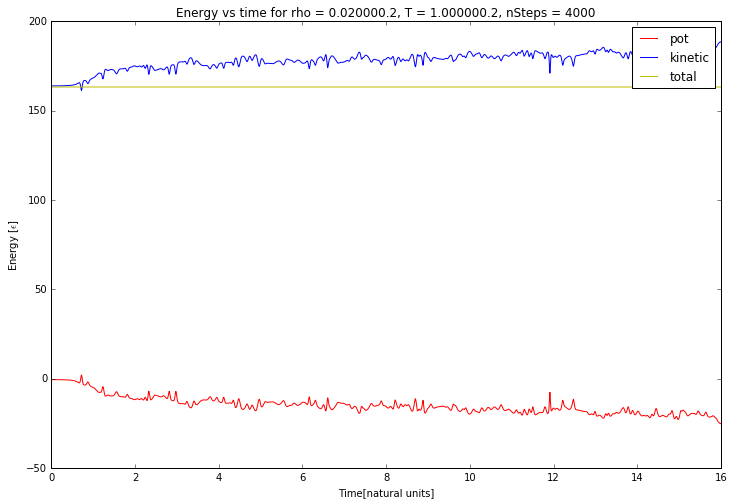

In [76]:
##--------- conserve E program --------------
x,y,z = init_pos()
vx,vy,vz = init_vel(Tinit)
x,y,z,vx,vy,vz,K,V,rV = evolveTimeConserveE(x,y,z,vx,vy,vz,timesteps)


plt.figure(figsize = (12,8))
plt.title("Energy vs time for rho = %f.2, T = %f.2, nSteps = %d" %( rho, Tinit, timesteps))
plt.plot([dt * j for j in range(0, timesteps)], V, 'r')
plt.plot([dt * j for j in range(0, timesteps)], K,  'b')
plt.plot([dt * j for j in range(0, timesteps)], K + V , 'y')
plt.xlabel('Time[natural units]')
plt.ylabel('Energy [$\epsilon$]')
plt.legend(('pot', 'kinetic', 'total'))

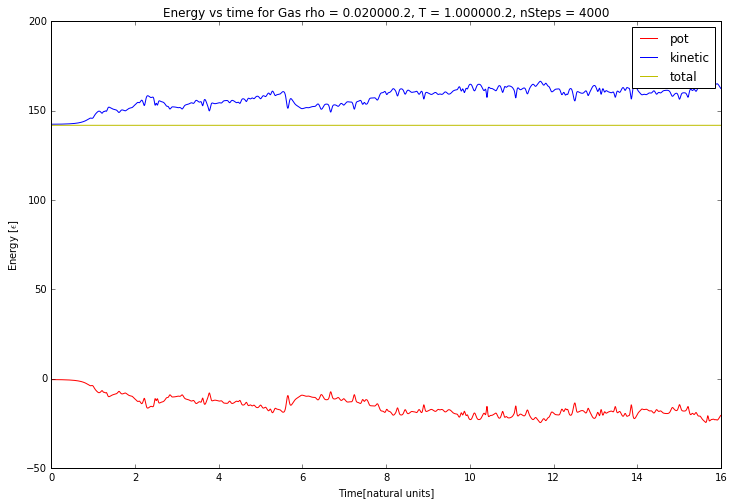

In [77]:
##--------- conserve E program --------------
x,y,z = init_pos()
vx,vy,vz = init_vel(Tinit)
x,y,z,vx,vy,vz,K,V,rV = evolveTimeConserveE(x,y,z,vx,vy,vz,timesteps)


plt.figure(figsize = (12,8))
plt.title("Energy vs time for Gas rho = %f.2, T = %f.2, nSteps = %d" %( rho, Tinit, timesteps))
plt.plot([dt * j for j in range(0, timesteps)], V, 'r')
plt.plot([dt * j for j in range(0, timesteps)], K,  'b')
plt.plot([dt * j for j in range(0, timesteps)], K + V , 'y')
plt.xlabel('Time[natural units]')
plt.ylabel('Energy [$\epsilon$]')
plt.legend(('pot', 'kinetic', 'total'))

In [8]:
# Force between particle i and j with correlation function implemented
@jit
def forceLJDis(xi,yi,zi,xj,yj,zj):
    dx = xi-(xj + np.around((xi-xj)/L)*L) 
    dy = yi-(yj + np.around((yi-yj)/L)*L) 
    dz = zi-(zj + np.around((zi-zj)/L)*L) 
    r2 = dx*dx + dy*dy + dz*dz    
    pref = 48/(r2**7) - 24/(r2**4)
    Fx = pref*dx
    Fy = pref*dy
    Fz = pref*dz
    V = 4/(r2**6) - 4/(r2**3)
    rV = -48/(r2**6) + 24/(r2**3) #r_ij * dV/dr (r_ij)
    return Fx, Fy, Fz, V, rV, r2

# Total force on each particle in a vector, and total potential energy of all particles.
@jit
def forceTotalDis(x,y,z):
    Fx = np.zeros(N)
    Fy = np.zeros(N)
    Fz = np.zeros(N)
    rM = np.zeros((N,N))
    
    V = 0.0
    rV = 0.0
    for i in range(N):
        for j in range(i):
            dFx,dFy,dFz,dV,drV, r2 = forceLJDis(x[i],y[i],z[i],x[j],y[j],z[j])
            Fx[i] += dFx
            Fy[i] += dFy
            Fz[i] += dFz
            rM[i,j] = np.sqrt(r2)
            rM[j,i] = np.sqrt(r2)
            # action = - reaction
            Fx[j] -= dFx
            Fy[j] -= dFy
            Fz[j] -= dFz
            
            V += dV
            rV += drV
    return Fx,Fy,Fz,V,rV,rM

def evolveTimeFixedTAndCalcN(x,y,z,vx,vy,vz,numtime, nBins):
    #Initialize potential energy vectors
    K = np.zeros(numtime)
    V = np.zeros(numtime)
    rV = np.zeros(numtime)

    nr = np.zeros((numtime, nBins))
    
    Fx,Fy,Fz,discard,discard2, rM = forceTotalDis(x,y,z)
    for i in range(numtime):
        vx += 0.5*dt*Fx
        vy += 0.5*dt*Fy
        vz += 0.5*dt*Fz        
        
        x += dt*vx
        y += dt*vy
        z += dt*vz
        x = x%L
        y = y%L
        z = z%L

        Fx,Fy,Fz,V[i],rV[i], rM = forceTotalDis(x,y,z)
        
        vx += dt/2*Fx
        vy += dt/2*Fy
        vz += dt/2*Fz  

        scale = np.sqrt(3*Tfixed/np.mean(vx**2+vy**2+vz**2))
        vx = scale*vx
        vy = scale*vy
        vz = scale*vz
        
        K[i] = 0.5*np.sum(vx*vx+vy*vy+vz*vz)
        #calculate n(r)
        nr[i,:], rVech = np.histogram(np.reshape(rM,-1), nBins, (0, np.sqrt(3) * L)) #nBin bin histogram
        
    #calculate g
    rVec = np.linspace(0, np.sqrt(3) * L, nBins)
    dr = rVec[1] - rVec[0]
    rVec += 0.5 * dr
    g = (L * L * L) / (N * (N-1)) * np.mean(nr[2000:numtime,:], axis = 0) / (4 * 3.14 * rVec ** 2 * dr)
        
        
        
    return x,y,z,vx,vy,vz,K,V,rV, g, rVec, nr


          

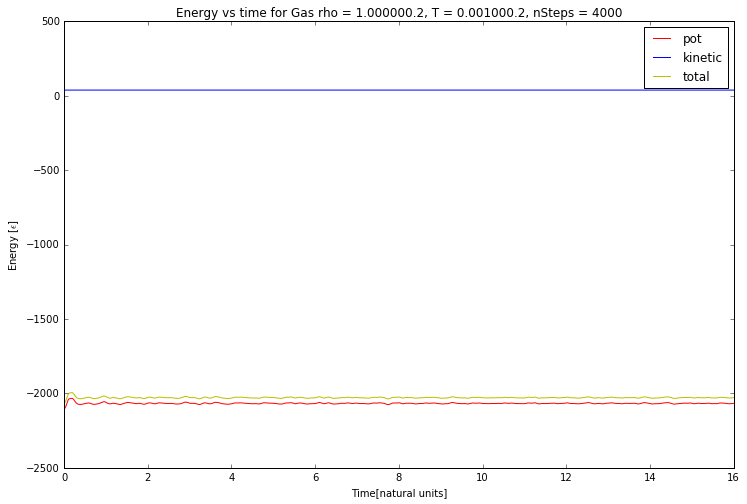

In [9]:
x,y,z = init_pos()
vx,vy,vz = init_vel(Tfixed)
x,y,z,vx,vy,vz,K,V,rV = evolveTimeFixedT(x,y,z,vx,vy,vz,timesteps)


plt.figure(figsize = (12,8))
plt.title("Energy vs time for Gas rho = %f.2, T = %f.2, nSteps = %d" %( rho, Tinit, timesteps))
plt.plot([dt * j for j in range(0, timesteps)], V, 'r')
plt.plot([dt * j for j in range(0, timesteps)], K,  'b')
plt.plot([dt * j for j in range(0, timesteps)], K + V , 'y')
plt.xlabel('Time[natural units]')
plt.ylabel('Energy [$\epsilon$]')
plt.legend(('pot', 'kinetic', 'total'))

(0, 10)

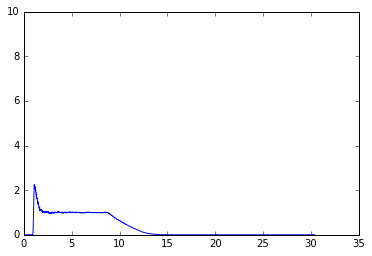

In [142]:
#for gas
x,y,z = init_pos()
vx,vy,vz = init_vel(Tfixed)
x,y,z,vx,vy,vz,K,V,rV, g, rVec, nr = evolveTimeFixedTAndCalcN(x,y,z,vx,vy,vz,timesteps, 5000)
plt.plot(rVec, g)
plt.ylim((0,10))

(0, 10)

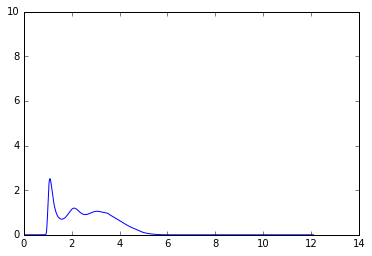

In [9]:
#for solid
x,y,z = init_pos()
vx,vy,vz = init_vel(Tfixed)
x,y,z,vx,vy,vz,K,V,rV, g, rVec, nr = evolveTimeFixedTAndCalcN(x,y,z,vx,vy,vz,timesteps, 1000)
plt.plot(rVec, g)
plt.ylim((0,10))

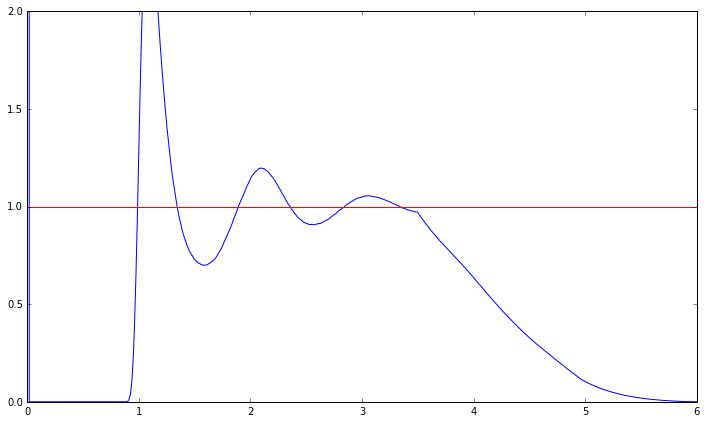

In [24]:
plt.figure(figsize = (12,7))
plt.plot(rVec, g)
plt.ylim((0,2))
plt.xlim((0,6))
plt.axhline(1, color="r")

From the correlation function graph above we can clearly see that the correlation function falls off after $R>3.5 \sigma$. This is due to the fact that we have a finite box size and do not keep in account the PBC when averaging this correlation function. So for small R this won't matter, but for larger R it results in the fall off


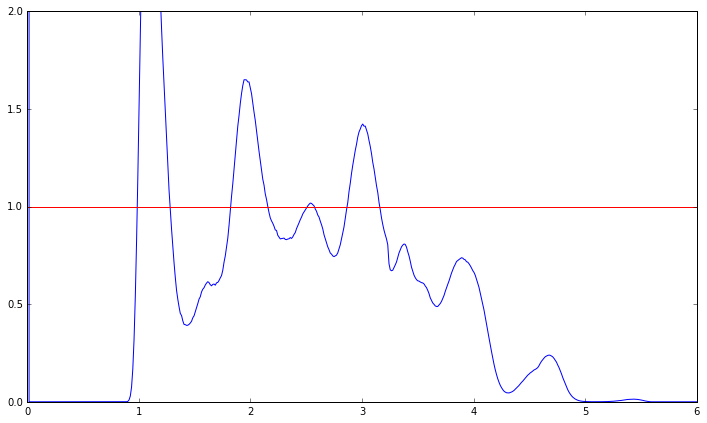

In [64]:
#for solid
x,y,z = init_pos()
vx,vy,vz = init_vel(Tfixed)
x,y,z,vx,vy,vz,K,V,rV, g, rVec, nr = evolveTimeFixedTAndCalcN(x,y,z,vx,vy,vz,timesteps, 1000)

plt.figure(figsize = (12,7))
plt.plot(rVec, g)
plt.ylim((0,2))
plt.xlim((0,6))
plt.axhline(1, color="r")

#rho = 0.95 t =0.1

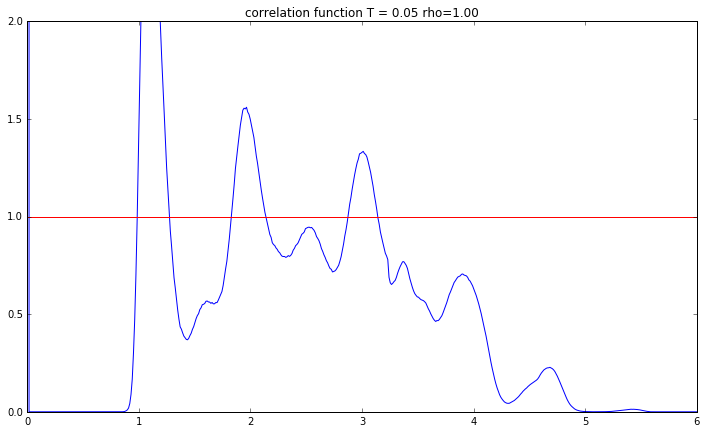

In [77]:
#for solid
x,y,z = init_pos()
vx,vy,vz = init_vel(Tfixed)
x,y,z,vx,vy,vz,K,V,rV, g, rVec, nr = evolveTimeFixedTAndCalcN(x,y,z,vx,vy,vz,timesteps, 1000)

plt.figure(figsize = (12,7))
plt.plot(rVec, g)
plt.ylim((0,2))
plt.xlim((0,6))
plt.axhline(1, color="r")
plt.title("correlation function T = %.2f rho=%.2f" % (Tinit, rho))


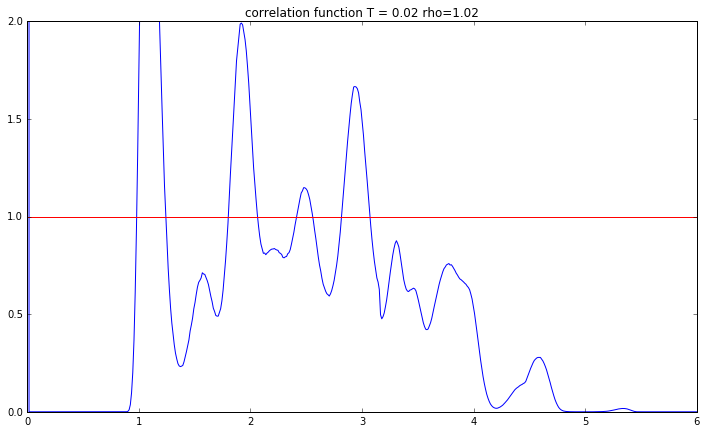

In [87]:
#for solid
x,y,z = init_pos()
vx,vy,vz = init_vel(Tfixed)
x,y,z,vx,vy,vz,K,V,rV, g, rVec, nr = evolveTimeFixedTAndCalcN(x,y,z,vx,vy,vz,timesteps, 1000)

plt.figure(figsize = (12,7))
plt.plot(rVec, g)
plt.ylim((0,2))
plt.xlim((0,6))
plt.axhline(1, color="r")
plt.title("correlation function T = %.2f rho=%.2f" % (Tinit, rho))


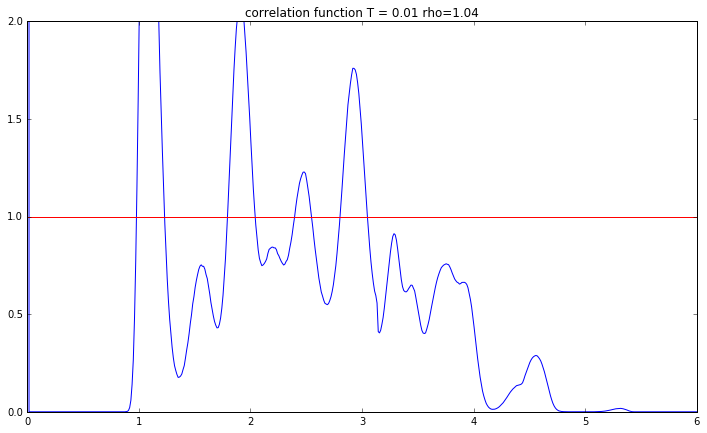

In [101]:
#for solid
x,y,z = init_pos()
vx,vy,vz = init_vel(Tfixed)
x,y,z,vx,vy,vz,K,V,rV, g, rVec, nr = evolveTimeFixedTAndCalcN(x,y,z,vx,vy,vz,timesteps, 1000)

plt.figure(figsize = (12,7))
plt.plot(rVec, g)
plt.ylim((0,2))
plt.xlim((0,6))
plt.axhline(1, color="r")
plt.title("correlation function T = %.2f rho=%.2f" % (Tinit, rho))

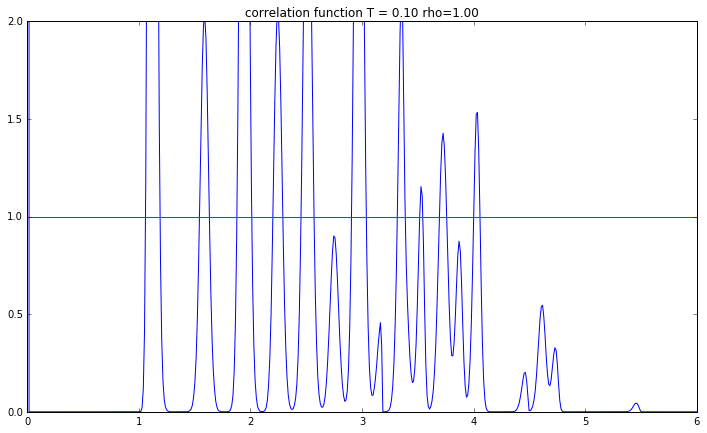

In [10]:
#for solid
x,y,z = init_pos()
vx,vy,vz = init_vel(Tfixed)
x,y,z,vx,vy,vz,K,V,rV, g, rVec, nr = evolveTimeFixedTAndCalcN(x,y,z,vx,vy,vz,timesteps, 1000)

plt.figure(figsize = (12,7))
plt.plot(rVec, g)
plt.ylim((0,2))
plt.xlim((0,6))
plt.axhline(1, color="r")
plt.title("correlation function T = %.2f rho=%.2f" % (Tfixed, rho))

# Calculate Cv b using the NVT ensemble

In [35]:
def calcCv(E):
    return 1/Tinit ** 2 * np.var(E) / N

C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


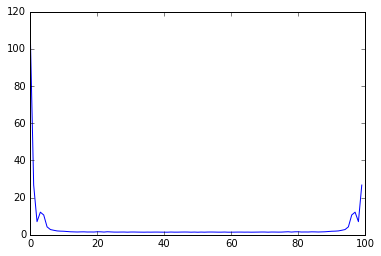

In [90]:
plt.plot(np.fft.fft(g[100:200]))